<a href="https://colab.research.google.com/github/annikapalm/Topic_Modeling_Dreams/blob/master/topic_modeling_dreams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling Dreams

### This Colab Notebook documents a process for analyzing a corpus of dream narratives and for training a topic model on it as well as to analyzse the results in various ways, including in a temporal dimension.

### **Frameworks used**:

#### [BERTopic](https://maartengr.github.io/BERTopic/)

#### [VADER](https://github.com/cjhutto/vaderSentiment)




### **Contents**:
####[1. Import libraries and packages](#imports)
####[2. Load in data](#loaddata)
####[3. Corpus statistics](#stats)
####[4. Training of the topic model](#train)
####[5. Topic visualization](#viz)
####[6. Dynamic topic modeling](#dynamic)
####[7. Sentiment analysis](#sent)
---




<a name="imports"></a>
# Import libraries and install packages

Run the code below to install the required packages, including BERTopic. Once the first cell is run, the run time environment has to be re-started. 

The subsequent import statements can then be run normally.

In [ ]:
!pip install bertopic PyDrive textstat langdetect

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

import pandas as pd
import pickle

import nltk
import spacy
import textstat
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from langdetect import detect
nltk.download('punkt')
nltk.download('stopwords')

import collections

import matplotlib.pyplot as plt
import numpy as np

from bertopic import BERTopic

from scipy.special import softmax

from collections import defaultdict, Counter

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a name="loaddata"></a>

# Load data


In [ ]:
# Authenticate Drive account

auth.authenticate_user() 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load 2021 corpus files from Drive
corpus_file = drive.CreateFile({'id' : '1L0qyDc6ZeXjxWY_h9ybut3TcqGHhj4qY'}) 
corpus_file.GetContentFile('corpus_final.pkl')

print('Corpus loaded successfully')

Corpus loaded successfully




---


Only run the code below to obtain the 2020 corpus!

In [ ]:
# Load in 2019 corpus files from Drive
corpus_file = drive.CreateFile({'id' : '1uMHOPMvH7pVXui47jqkewh7hJpRyi9Tw'}) 
corpus_file.GetContentFile('corpus_old.pkl')

print('Corpus loaded successfully')

# Read in pickled DataFrames
with open('corpus_old.pkl', 'rb') as f:
  data = pickle.load(f)

data['year'] = pd.DatetimeIndex(data['timestamp']).year

data = data[data['year'] == 2019]
data = data.drop_duplicates(subset=['text'], keep='first')
docs = data['text'].tolist()

---------------------------

In [ ]:
# Open pickled DataFrames

with open('corpus_final.pkl', 'rb') as f:
  data = pickle.load(f)

# Sort DataFrames according to timestamps
data.sort_values('timestamp', inplace=True) 

# Drop duplicates
data = data.drop_duplicates(subset=['text'], keep='first') 

# Save texts from DataFrames as list for futher processing
docs = data['text'].tolist() 

In [ ]:
print('Number of documents: ' + str(len(docs)))

Number of documents: 13421


<a name="stats"></a>

# Corpus statistics
Enrich Corpus with additional information

In [ ]:
# The documents are tokenized to process words individually

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
data['tokenized text'] = data['text'].apply(tknzr.tokenize)

docs = data['tokenized text'].tolist()

In [ ]:
# Count text lengths

data['text length'] = data['tokenized text'].apply(len)
doc_lens = data['text length'].tolist()

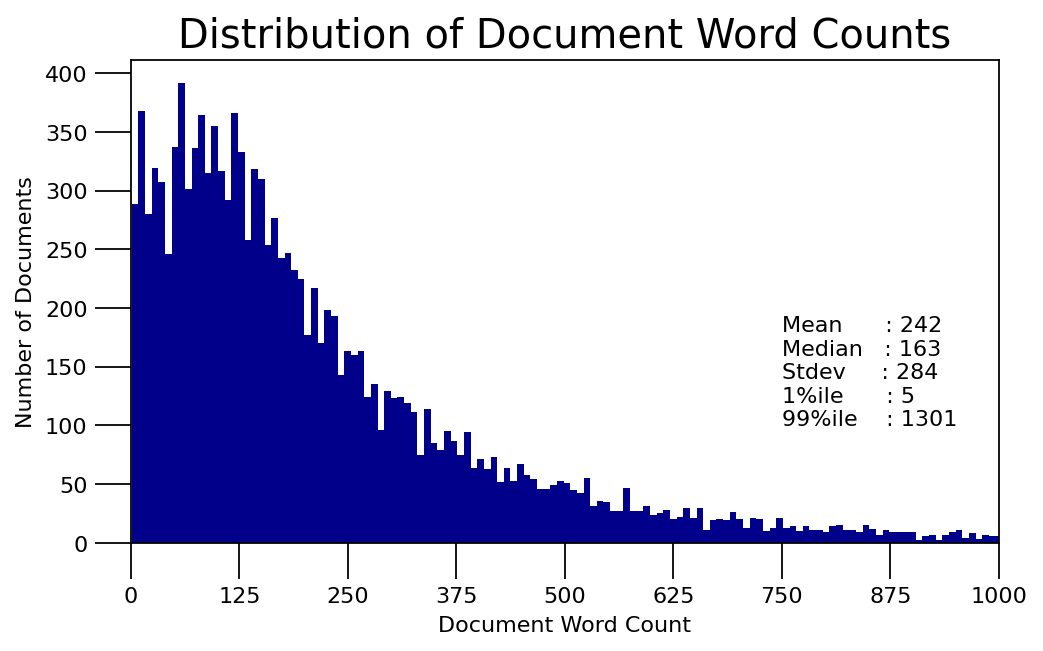

In [ ]:
# Create a graph with the matplotlib library to plot the distribution of word counts

plt.figure(figsize=(7,4), dpi=160)
plt.hist(doc_lens, bins=1000, color='darkblue')
plt.text(750, 180, 'Mean'.ljust(10)  +  ": " + str(round(np.mean(doc_lens))))
plt.text(750,  160, 'Median'.ljust(9)  +  ": " + str(round(np.median(doc_lens))))
plt.text(750,  140, 'Stdev'.ljust(10)  +  ": " + str(round(np.std(doc_lens))))
plt.text(750,  120, '1%ile'.ljust(11)  +  ": " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  100, '99%ile'.ljust(10)  +  ": "+ str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=18))
plt.show()

In [ ]:
data['number of sentences'] = data['text'].apply(textstat.sentence_count) # Average number of sentences

print('Average number of sentences per document: ' + str(round(data['sentence nr.'].mean(), 2)))
print('Median number of sentences per document: ' + str(round(data['sentence nr.'].median(), 2)))

Average number of sentences per document: 8.84
Median number of sentences per document: 5.0


In [ ]:
# Average readability 
data['readability'] = data['text'].apply(textstat.flesch_reading_ease)

print('Average readbility of the corpus: ' + str(round(data['readability'].mean(), 2)))

Average readbility of the corpus: 58.6


In [ ]:
# Lexical diversity

all_tokens = [word for doc in docs for word in doc if word.isalpha()]
print('Total number of tokens: ' + str(len(all_tokens)))

print('The lexical diversity (TTR) of the corpus is ' + str(round(len(set(all_tokens)) / len(all_tokens)*100,2)))

Total number of tokens: 2852621
The lexical diversity (TTR) of the corpus is 1.53


In [ ]:
# Detect languages
data['lang'] = data['text'].apply(detect)
data['lang'].value_counts()

non_eng = data['lang']!='en'
non_eng_df = data[non_eng]
candidates = non_eng_df['text'].tolist()
candidates[-10:]

['Monster Dream???? ',
 'Siren. 2012 ',
 'fascinating! ',
 'Smile in a dream ',
 '😳 (real) ',
 '#Dreamscapes Episode 48: Nkwe Kgogo ',
 'Spider turned into dog ',
 'Sussy ',
 'Rüyada korkmak ne anlama gelmektedir ? | Rüyada korkmak neye işarettir ? ',
 'GIẤC MƠ KÌ LẠ CỦA TÔI - MY STRANGE DREAM  \n\nNói vậy thôi chứ hầu như là giấc mơ nào chả kì lạ.\n\nĐại khái là đêm qua tôi đã mơ một giấc mơ kì quái. Trong giấc mơ tôi gặp một cô bé đứng trong vườn, hình như nó là em gái của tôi í (em gái của tôi trong giấc mơ chứ ngoài đời tôi có chị thôi). Con bé cứ đứng trong vườn một lúc lâu, tôi đã lại hỏi nó làm gì vậy thì nó quay lại và chỉ nói :"Ngôi nhà 5 bước"\n\nMột lúc sau thì người làm vườn đi ra từ một căn phòng và cũng nói câu :"Ngôi nhà 5 bước" y chang vậy\n\nSau đó thì tôi tỉnh dậy.\n\nTính ra thì giấc mơ cũng không có gì nhưng tôi thật sự muốn biết "Ngôi nhà 5 bước" là gì. Tôi vô cùng tò mò. Nếu nó chỉ có trong giấc mơ nhảm nhí của tôi thì cũng không sao.\n\nThat said, almost dream is

In [ ]:
out_file = non_eng_df.to_excel('non_eng.xlsx')
files.download('non_eng.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Count non-English texts

non_eng_df['lang'].value_counts()

de    13
ca    12
cy     7
ro     5
af     5
no     5
es     4
fr     3
nl     3
da     3
pt     2
id     2
tl     2
vi     2
it     1
sw     1
fi     1
tr     1
hi     1
lv     1
uk     1
et     1
lt     1
Name: lang, dtype: int64

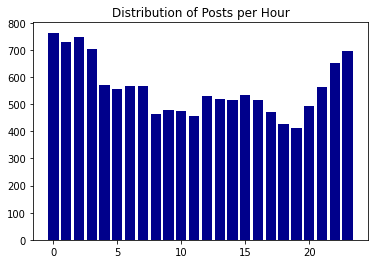

In [ ]:
# Statistics concerning posting times

timestamps = data['timestamp'].tolist()
post_times = [timestamp.hour for timestamp in timestamps]

time_counter = collections.Counter(post_times)
sorted_times = time_counter.most_common()
#for tpl in sorted_times:
#  print(str(tpl[0]) + ': ' + str(tpl[1]))

plt.title("Distribution of Posts per Hour")
plt.bar(*zip(*sorted_times), color='darkblue')
plt.show()

In [ ]:
stats['mean doc length'] = float(np.mean(doc_lens))
stats['total token count'] = len(all_tokens)
stats['avg # of sentences per doc'] = float(round(data['sentence nr.'].mean(), 2))
stats['avg readability of corpus'] = round(data['readability'].mean(), 2)
stats['# of non-eng. docs'] = len(candidates)
stats['most popular posting time'] = sorted_times[0][0]

stats_df = pd.DataFrame.from_dict(stats, orient="index")
stats_df['value'] = stats_df[0].astype(int)
stats_df.drop(0, axis=1, inplace=True)

In [ ]:
stats_df

,value
mean doc length,242
total token count,2852621
avg # of sentences per doc,8
avg readability of corpus,58
# of non-eng. docs,77
most popular posting time,0


In [ ]:
# Join lists back into strings

docs = [' '.join(text) for text in docs]

<a name="train"></a>
 # Train the topic model

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, min_topic_size=10, 
                       embedding_model="distilbert-base-nli-stsb-mean-tokens") #, nr_topics=80,  min_topic_size=30, nr_topics='auto'
topics, probs = topic_model.fit_transform(docs)

2021-07-29 19:46:56,587 - BERTopic - Transformed documents to Embeddings


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-07-29 19:47:28,025 - BERTopic - Reduced dimensionality with UMAP
2021-07-29 19:47:42,660 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.get_topic_freq().head(10)

,Topic,Count
0,-1,7302
1,0,548
2,1,271
3,2,268
4,3,186
5,4,178
6,5,144
7,6,132
8,7,124
9,8,114


-1 refers to all outliers and should typically be ignored.

In [ ]:
# Sample topic

topic_model.get_topic(-1)

[('house', 0.002597948889022942),
 ('remember', 0.0025750192139526906),
 ('woke', 0.002550798859822157),
 ('would', 0.0025203682621764817),
 ('don', 0.0025183429604670924),
 ('time', 0.0024949552740292594),
 ('room', 0.002485937711231539),
 ('could', 0.002481411947474902),
 ('back', 0.0024626750424820193),
 ('into', 0.002454633301577205)]

In [ ]:
all_topics = topic_model.get_topics()
all_topics = pd.DataFrame.from_dict(all_topics)
all_topics.columns=['Topic ' + str(i) for i in range(-1, len(all_topics.keys())-1)]
#all_topics

In [ ]:
# Remove probabilities from DataFrame

def remove_prob(item):
  return item[0]

all_topics_words = pd.DataFrame()
for colname, col in all_topics.iteritems():
  all_topics_words[colname] = all_topics[colname].apply(remove_prob)
all_topics_words

,Topic -1,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,...,Topic 106,Topic 107,Topic 108,Topic 109,Topic 110,Topic 111,Topic 112,Topic 113,Topic 114,Topic 115,Topic 116,Topic 117,Topic 118,Topic 119,Topic 120,Topic 121,Topic 122,Topic 123,Topic 124,Topic 125,Topic 126,Topic 127,Topic 128,Topic 129,Topic 130,Topic 131,Topic 132,Topic 133,Topic 134,Topic 135,Topic 136,Topic 137,Topic 138,Topic 139,Topic 140,Topic 141,Topic 142,Topic 143,Topic 144,Topic 145
0,house,boyfriend,killed,ocean,school,nightmares,bathroom,alien,dog,weed,video,three,sleep,zombie,com,snake,dad,sex,teeth,cat,else,store,recreated,snow,join,pc,write,pizza,souls,met,dog,grandma,dreamscapes,never,die,fly,bed,mall,car,house,...,carvings,scorpion,storm,minutes,moon,bed,tea,dumpster,plane,kingdom,man,tyler,mushrooms,pregnant,read,living,fauna,dad,crow,lava,bed,ichtyander,cow,boat,deja,scary,vegan,monster,video,plenty,346912,birthday,labyrinth,nightmares,fear,nightmares,orange,sleep,lava,anime
1,remember,love,kill,fish,teacher,wake,toilet,space,dogs,smoking,movie,satyr,asleep,zombies,podcast,snakes,grandpa,psychologist,tooth,cats,memories,mall,recreate,ice,discourse,mouse,journal,sandwich,always,never,friends,grandmother,dreamline,lisa,death,flying,pok,malls,driving,apartment,...,bugs,scorpions,asleep,sleep,comet,alarm,bed,screamed,flying,wizard,dimes,pants,mushroom,birth,knowledge,sober,doe,abusive,chicken,hell,paralysis,brother,meat,soul,vu,nightmares,weevil,socket,youtube,cosmopolitan,rallying,aunt,graveyard,teeth,nightmare,infinity,lightning,asleep,steal,devil
2,woke,crush,shooting,swimming,class,nightmare,water,aliens,puppy,smoke,his,darkness,bed,apocalypse,lucid,lizard,father,rape,mouth,tiger,sometimes,shopping,scene,forest,metamorphosis,room,werewolf,food,every,ve,nickelodeon,aunt,catboy,love,died,plane,thought,store,crash,attic,...,purple,worms,woke,wake,eclipse,woke,skinner,billions,planes,ticket,fish,house,fungus,pegg,reading,boyfriend,killing,father,hawk,killer,sleep,cultists,cows,floating,wolves,bear,lizard,dwarves,https,everyone,mcgill,jane,mosquitoes,claws,evil,feeling,fire,paralysis,heaven,japan
3,would,relationship,cut,lake,students,sleep,shower,planet,pet,drugs,garage,halo,lucid,off,sleep,bite,brother,sexual,gum,kitten,dreams,elevator,made,mountain,interpretation,bed,fortune,taco,tranquilizer,other,owl,died,vyvx,wish,dead,wings,sleep,elevator,drive,home,...,night,worm,sleep,20th,planets,paralysis,bathroom,creation,crashed,market,dress,kitchen,mycelium,simon,words,table,witch,narcissist,dove,red,slimy,wife,saddle,submarine,freezing,myers,cave,exhibit,l5a48qpzc,open,covid19dreamsstudy,chinese,aunt,nightmare,hospital,often,lit,dreaming,doppelgängers,monster
4,don,friend,knife,sea,classroom,feeling,toilets,elevator,died,cannabis,mario,weird,wake,saw,dreaming,cobra,died,counseling,tongue,kittens,life,floor,kitkat,cold,converse,woke,dreaming,burger,ever,anyone,bubble,mom,dreamonicle,remember,dying,birds,door,candy,highway,houses,...,hell,ants,05,dinner,saturn,sleep,downstairs,pirates,crane,universe,boat,tv,skeleton,crying,patients,birthday,nightmares,crying,stabbing,pig,smoke,three,eater,raisins,temperatures,nightmare,purple,pizza,vhs,every,gmail,stove,dolls,horrifying,scare,sleep,smoke,brain,doll,bedthingy
5,time,friends,stabbed,drowning,math,always,bath,sky,dad,drug,mickey,third,dreaming,kill,memory,venom,grandfather,partner,dentist,pet,remembering,aesha,relators,snowing,interpret,white,night,chef,night,miley,inside,deceased,pentimento,met,afterlife,swing,phone,city,jaguar,mannequin,...,weird,lobsters,spacecrafts,sequential,venus,vibrating,suprise,oracle,747,magic,saw,apartment,stew,father,hypnotized,older,kill,abuse,birds,monster,demon,companions,steak,tugboat,

In [ ]:
 nr_of_topics = len(all_topics.keys())
print('Number of topics: ' + str(nr_of_topics))

Number of topics: 147


In [ ]:
# Save dataframe

out_file = all_topics_words.to_excel('topics.xlsx')
files.download('topics.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model

topic_model.save('model_6', save_embedding_model=False)

TypeError: ignored

In [ ]:
# Load model

topic_model = BERTopic.load('model_6')
topics, probs = topic_model.fit_transform(docs)

<a name="viz"></a>
# Visualize topics

In [ ]:
#topic_model.visualize_topics()



The variable `probabilities` that is returned from `transform()` or `fit_transform()` can 
be used to understand how confident BERTopic is that certain topics can be found in a document. 


In [ ]:
#topic_model.visualize_distribution(probs[2])

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

In [ ]:
#topic_model.visualize_heatmap()

In [ ]:
#topic_model.visualize_hierarchy()

# Search Topics
Problem der Zuordnung von Topics zu Dokumenten!!

In [ ]:
similar_topics, similarity = topic_model.find_topics("virus", top_n=5); similar_topics

Exception: ignored

In [ ]:
for topic in similar_topics:
  print(topic_model.get_topic(topic))

NameError: ignored

In [ ]:
# Topics mit topic probs zusammenführen, Ordnung stimmt jedoch nicht überein! Lösung?

topic_nrs = [i for i in range(-1, nr_of_topics-1)]
doc_nrs = [i for i in range(0, len(docs))]
topic_probs = [dict(zip(topic_nrs, prob))for prob in probs]
doc_probs = list(zip(doc_nrs, topic_probs))
doc_dict = dict(zip(doc_nrs, docs))

In [ ]:
import operator

result = []
for entry in doc_probs:
  dct = entry[1]
  sorted_entry = sorted(dct.items(), key=operator.itemgetter(1))
  result.append((entry[0], sorted_entry))

In [ ]:
filter = []
for res in result:
  probs = res[1]
  top = probs[-1][0]
  if top == -1:
    filter.append(res[0])

In [ ]:
# Die Dokumente gehören nicht zu topic -1 !!

for key in doc_dict.keys():
  if key in filter:
    print(doc_dict[key])

On an island with spiders looking for treasure . I dreamt once I was with a crew of pirates . The captain was some 50 something year old guy wearing a bandana . I think the crew was about five men total including myself . We had giant orange spiders on leashes that were used to sniff out the treasure and they acted like dogs . One of the spiders lifted it's front legs and made a shrieking sound alerting us to the treasure . I ran to see the treasure but I woke up before I could see it .
Spider covered bicycle So in the dream I was at work and for some reason all of a sudden we all needed to get on our bicycles ( my work has never involved bikes at all ) everyone got o their bikes and peddled away but my bike has thousands of spiders crawling all over it . Then out of nowhere a hand sized praying mantis came and killed all the spiders , the praying mates wasn't a normal one , it was like a crab shelled preying mantis or something . Then I woke up 🤔
I had a dream about a spider with 13 l

<a name="dynamic"></a>
# Dynamic topic modeling

In [ ]:
# Extract timestamps from DataFrames

#timestamps = filtered['timestamp'].tolist()
timestamps = data['timestamp'].tolist()

print('Oldest post: ' + str(timestamps[0]))
print('Most recent post: ' + str(timestamps[-1]))

Oldest post: 2021-01-29 22:13:37
Most recent post: 2021-06-02 04:23:34


In [ ]:
topics_over_time = topic_model.topics_over_time(docs, topics, timestamps, nr_bins=30)

30it [00:13,  2.20it/s]


In [ ]:
t = topics_over_time[topics_over_time['Topic'] == 0]

In [ ]:
t.sort_values(by=['Timestamp'])

In [ ]:
# Calculate Sentiment Compund Score
def find_compound_score(df):
  vs = analyzer.polarity_scores(df)
  return vs['compound']

In [ ]:
topics_over_time['Sentiment'] = topics_over_time['Words'].apply(find_compound_score)

In [ ]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Sentiment
0,-1,"remember, felt, don, woke, would",238,2021-01-29 19:16:07.603000064,0.0000
1,0,"stepdad, guy, cattle, ex, kissed",13,2021-01-29 19:16:07.603000064,0.3818
2,1,"mike, sam, shot, hole, gun",8,2021-01-29 19:16:07.603000064,-0.3400
3,2,"water, arches, rushing, products, ships",5,2021-01-29 19:16:07.603000064,0.0000
4,3,"school, stocky, students, class, before",9,2021-01-29 19:16:07.603000064,0.0000
...,...,...,...,...,...
2569,122,"hurt, grown, vaguely, shook, dress",1,2021-05-29 01:47:14.100000000,-0.5859
2570,123,"dated, warning, appropriate, destiny, tall",1,2021-05-29 01:47:14.100000000,-0.3400
2571,129,"tugboat, graveyard, 40s, boats, spirits",1,2021-05-29 01:47:14.100000000,-0.2960
2572,135,"options, lack, coffee, forced, upset",1,2021-05-29 01:47:14.100000000,-0.7845


In [ ]:
#NUM_TOPICS = 5
SELECTED_TOPICS = [0,6,4]
t = topics_over_time.sort_values(by=['Timestamp'])

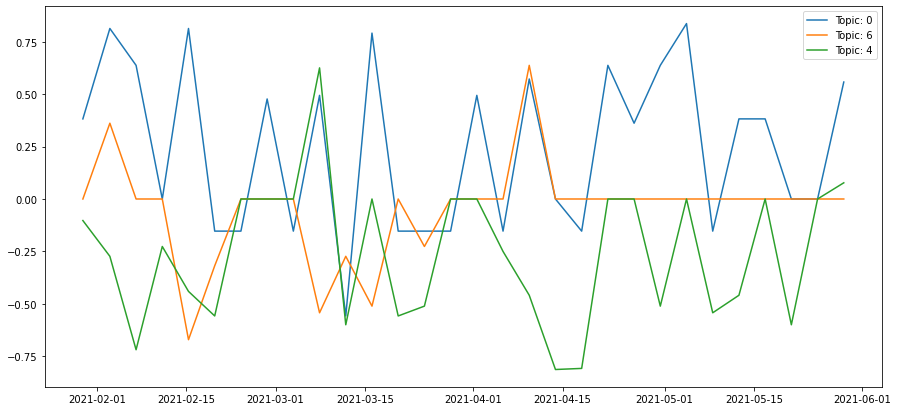

In [ ]:
plt.figure(figsize=(15,7)) 

for num in SELECTED_TOPICS:
  plt.plot(t[t['Topic']==num]['Timestamp'], t[t['Topic']==num]['Sentiment'], '-', label='Topic: '+str(num))

plt.legend()
plt.show()

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

In [ ]:
topic_model.get_topic(22)

[('cats', 0.1599159090146199),
 ('dino', 0.04132308041683897),
 ('kitten', 0.03482766400089761),
 ('kittens', 0.03317369869043738),
 ('dinos', 0.016979999159020143),
 ('toes', 0.016684548341402212),
 ('dinosaur', 0.016226148645063054),
 ('dogs', 0.01336090817197193),
 ('pets', 0.011749604827450428),
 ('kitty', 0.011269931022774264)]

<a name="sent"></a>
# Sentiment Analysis

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 3.9 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [ ]:
counter = -1

topic_sentiments = {}
for colname, col in all_topics.iteritems():
  topic_words = [word for word in all_topics_words[colname].tolist()]
  topic_words = " ".join(topic_words)
  #print(topic_words)
  vs = analyzer.polarity_scores(topic_words)
  topic_sentiments['topic ' + str(counter)] = (vs['compound'], topic_words)

  counter+=1


In [ ]:
topic_sentiments

{'topic -1': (0.0,
  'woke because people remember back would can after ve could'),
 'topic 0': (0.0,
  'ocean fish swimming lake waves sea drowning swim boat underwater'),
 'topic 1': (-0.4019,
  'nightmares sleep wake nightmare night paralysis always feeling vivid fear'),
 'topic 10': (0.0258,
  'video youtube vr music playing watching pc movie ipad weird'),
 'topic 100': (0.0,
  'asthmatic bugs cough mask snake demon masks succubus caterpillar dreamt'),
 'topic 101': (0.0, 'que el por mơ cuarto con despertar thì vez primero'),
 'topic 102': (-0.2263,
  'bizarre weirdcore weird trippy overwhelmed strangest strange night dreams fearmongering'),
 'topic 103': (-0.9607,
  'satan devil demons demon devils rape raped satans occultic buffy'),
 'topic 104': (0.0,
  'spiders brain doors real lucid fiance shafts walled trying open'),
 'topic 105': (0.4939,
  'bike biking bridge bicycle friend cliff ride highway meadow july'),
 'topic 106': (0.0,
  'home wallet dolls keys grannies boobs charge

In [ ]:
sorted_dict = dict(sorted(topic_sentiments.items(), key=lambda item: item[1][0]))

In [ ]:
sorted_dict

{'topic -1': (0.0,
  'woke because people remember back would can after ve could'),
 'topic 0': (0.0,
  'ocean fish swimming lake waves sea drowning swim boat underwater'),
 'topic 1': (-0.4019,
  'nightmares sleep wake nightmare night paralysis always feeling vivid fear'),
 'topic 10': (0.0258,
  'video youtube vr music playing watching pc movie ipad weird'),
 'topic 100': (0.0,
  'asthmatic bugs cough mask snake demon masks succubus caterpillar dreamt'),
 'topic 101': (0.0, 'que el por mơ cuarto con despertar thì vez primero'),
 'topic 102': (-0.2263,
  'bizarre weirdcore weird trippy overwhelmed strangest strange night dreams fearmongering'),
 'topic 103': (-0.9607,
  'satan devil demons demon devils rape raped satans occultic buffy'),
 'topic 104': (0.0,
  'spiders brain doors real lucid fiance shafts walled trying open'),
 'topic 105': (0.4939,
  'bike biking bridge bicycle friend cliff ride highway meadow july'),
 'topic 106': (0.0,
  'home wallet dolls keys grannies boobs charge